# Modelo de Procesamiento de Datos de Audio

Autores:

- Juan Diego Díaz Guzmán
- Juan Carlos Cerón Lombana
- Juan Sebastian Cely Bottía
    
## Introducción

El modelo consiste en la captura y el procesamiento de datos de audio a partir de un dispositivo móvil para desarrollar un modelo de inteligencia artificial con capacidades de clasificación.

## Marco Teórico

// Incluir marco teórico relacionado con el caso de estudio

## Descripción del problema a solucionar

Se pretende desarrollar un modelo de inteligencia artificial mediante redes neuronales que sea capaz de clasificar correctamente datos de audio con voces para las palabras: corriendo, caminando, reposo, arriba, abajo, ola, izquierda y derecha. Se pretende entrenar el modelo con audios etiquetados y comprobar su precisión mediante métricas establecidas. 

## Planteamiento de la solución

In [46]:
# importación de librerías
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import numpy as np
from IPython import display
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

### Carga de los datos

In [47]:
# Función de carga para archivos de audio en canal mono
def load_wav_16k_mono(filename):
    file_contents = tf.io.read_file(filename) # Carga de archivo .wav
    wav, sample_rate = tf.audio.decode_wav(file_contents, desired_channels=1) # Decodificación wav (tensores por canales)    
    wav = tf.squeeze(wav, axis=-1) # Removiendo eje final    
    return wav # Devuelve archivo como vector numpy

### Carga de muestra de audio 

In [48]:
# Definición de ruta para archivos de audio
PATH = "../data/audio/corriendo-js1.wav"
wave = load_wav_16k_mono(PATH) # Carga de audio de muestra
print(wave.shape) # Dimensiones del audio
display.display(display.Audio(wave, rate=16000)) # Reproducción del audio 

(16000,)


In [49]:
# Función para generar espectrograma a partir de las muestras de audio.
def preprocess(wave):
    wav = wave[:16000] 
    spectrogram = tf.signal.stft(wav, frame_length=255, frame_step=128) # transformada de Fourier para conversión de datos
    spectrogram = tf.abs(spectrogram) # valores absolutos de la transformada
    return spectrogram

In [50]:
# Prueba de la función para espectrograma
espectrograma = preprocess(wave)
print("Waveform shape:", wave.shape)
print("Spectrogram shape:", espectrograma.shape)

Waveform shape: (16000,)
Spectrogram shape: (124, 129)


In [51]:
"""
Función para graficar el espectrograma.
Convierte las frecuencias a una escala logarítmica 
de manera que el tiempo se representa en el eje x (columnas).
"""

def plot_spectrogram(espectrograma, ax):
  # conversión a escala logarítmica
  log_spec = np.log(espectrograma.T)
  # dimensiones de los datos
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  # dimensiones de la gráfica 
  X = np.linspace(0, np.size(espectrograma), num=width, dtype=int)
  Y = range(height)
  # almacenamiento del plot en el eje
  ax.pcolormesh(X, Y, log_spec)

C:\Users\Sebastian\AppData\Local\Temp\ipykernel_25324\1659474332.py:9: RuntimeWarning: divide by zero encountered in log
  log_spec = np.log(espectrograma.T)


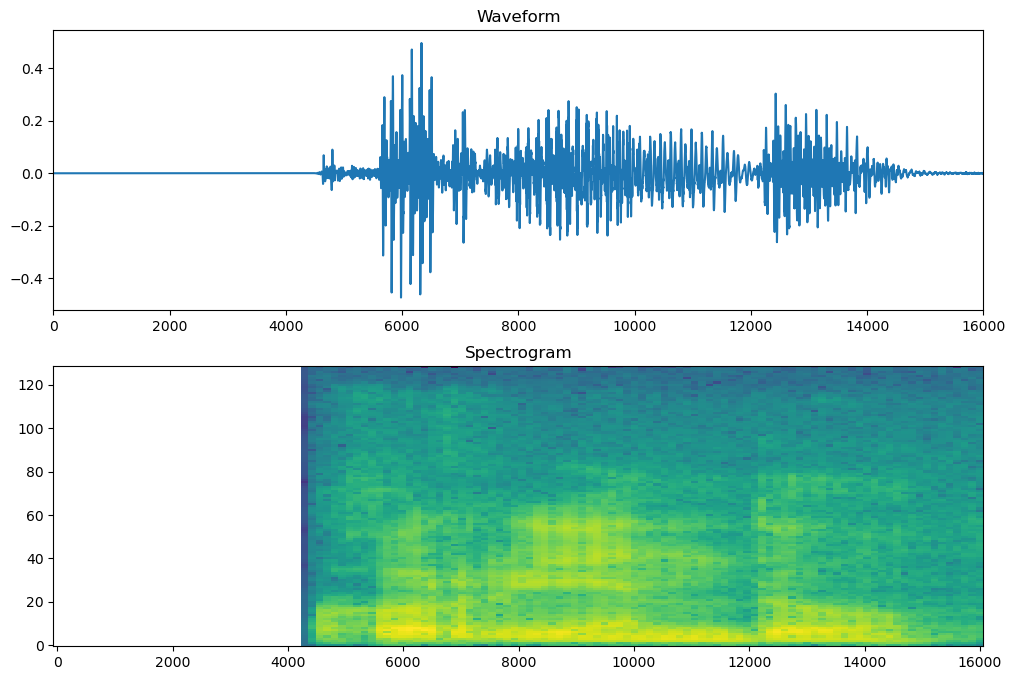

In [52]:
"""
Gráfica del primer audio de prueba, se establecen 2 subplots. 
El primer subplot es para la gráfica de frecuencias
El segundo subplot es para el espectrograma
"""

fig, axes = plt.subplots(2, figsize=(12, 8))
# Se establece la escala temporal en periodos fijos
timescale = np.arange(wave.shape[0])
# configuración de los parámetros del plot
axes[0].plot(timescale, wave.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 16000])
plot_spectrogram(espectrograma.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.show()

### Carga de audios por lote

Se cargan los datos de audio y se definen las características X y las clases de la variable objetivo Y. 

In [53]:
import os
"""
Función para crear una lista con los nombres de archivo 
de audio presentes en la ruta especificada. Además, se 
extrae la clase de cada audio.
"""

def listFiles(path):
    audioFiles = []
    targets = []
    for fileName in os.listdir(path):
        audioFiles.append(fileName)
        targets.append(fileName.split("-")[0])
    return audioFiles, targets

# Carga de los archivos de audio
path = "../data/audio" 
archivos, Y = listFiles(path)
print(len(archivos))
print(len(Y))

36
36


In [54]:
# Arreglo de espectrogramas de lso audios
X = np.zeros((len(archivos), 124, 129))

# Carga y generación de espectrogramas de cada archivo de audio
for i, archivo in enumerate(archivos):
    wave = load_wav_16k_mono(f'{path}/{archivo}')
    espectrograma = preprocess(wave)
    X[i,:,:] = espectrograma

print(X.shape)

# Expansión de la variable a 4 dimensiones para procesarla con el modelo
X = np.expand_dims(X, axis=3)
print(X.shape)

(36, 124, 129)
(36, 124, 129, 1)


In [55]:
# Codificación de la variable objetivo
encoder = LabelEncoder()
encoder.fit(Y)
Y_encoded = encoder.transform(Y)
Y_encoded = keras.utils.to_categorical(Y_encoded)
Y_encoded.shape

(36, 2)

In [56]:
# Separación del conjunto de entrenamiento y de pruebas
X_train, X_test, y_train, y_test = train_test_split(X, Y_encoded, test_size = 0.2, random_state = 0)
y_train = np.array(y_train)
y_test = np.array(y_test)
# Comprobación de dimensiones
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (28, 124, 129, 1)
X_test shape: (8, 124, 129, 1)
y_train shape: (28, 2)
y_test shape: (8, 2)


### Definición y entrenamiento de la red neuronal

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_20 (Conv2D)          (None, 124, 129, 8)       80        
                                                                 
 conv2d_21 (Conv2D)          (None, 124, 129, 16)      1168      
                                                                 
 conv2d_22 (Conv2D)          (None, 124, 129, 32)      4640      
                                                                 
 conv2d_23 (Conv2D)          (None, 124, 129, 64)      18496     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 62, 65, 64)        0         
 g2D)                                                            
                                                                 
 flatten_5 (Flatten)         (None, 257920)            0         
                                                      

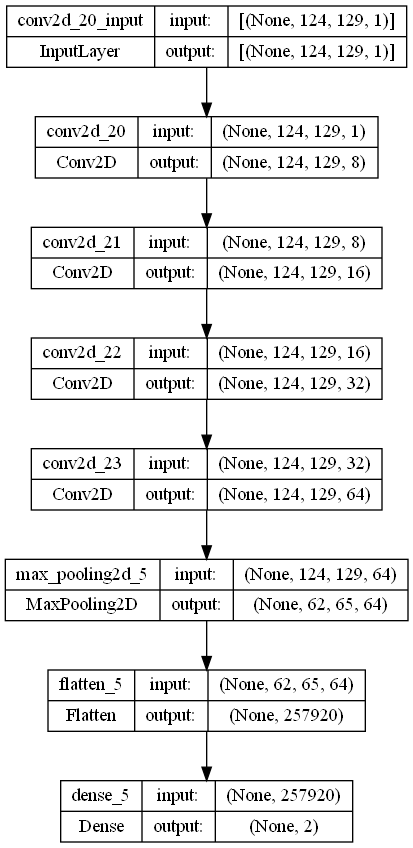

In [62]:
# Número de clases de salida para la red neuronal
n_clases = len(np.unique(Y_encoded))

# Definición del modelo secuencial de la red neuronal
modelo = keras.models.Sequential()
modelo.add(keras.layers.Conv2D(8, 3, activation="relu",padding="same", input_shape=(124,129,1)))
modelo.add(keras.layers.Conv2D(16, 3, activation="relu",padding="same"))
modelo.add(keras.layers.Conv2D(32, 3, activation="relu",padding="same"))
modelo.add(keras.layers.Conv2D(64, 3, activation="relu",padding="same"))
modelo.add(keras.layers.MaxPooling2D(pool_size=2,strides=2, padding='same'))
modelo.add(keras.layers.Flatten())
modelo.add(keras.layers.Dense(n_clases, activation = 'softmax'))

modelo.summary()
keras.utils.plot_model(modelo, to_file='model_plot1.png', show_shapes=True, show_layer_names=True)

In [58]:
# Compilación y entrenamiento del modelo neuronal
modelo.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
historia = modelo.fit(X_train, y_train, epochs=15,batch_size=None)

Epoch 1/15
1/1 [==============================] - 2s 2s/step - loss: 0.7070 - accuracy: 0.5000
Epoch 2/15
1/1 [==============================] - 1s 840ms/step - loss: 0.4436 - accuracy: 0.8571
Epoch 3/15
1/1 [==============================] - 1s 890ms/step - loss: 0.2329 - accuracy: 0.8571
Epoch 4/15
1/1 [==============================] - 1s 970ms/step - loss: 0.1193 - accuracy: 0.9643
Epoch 5/15
1/1 [==============================] - 1s 965ms/step - loss: 0.0741 - accuracy: 1.0000
Epoch 6/15
1/1 [==============================] - 1s 892ms/step - loss: 0.0564 - accuracy: 1.0000
Epoch 7/15
1/1 [==============================] - 1s 880ms/step - loss: 0.0357 - accuracy: 1.0000
Epoch 8/15
1/1 [==============================] - 1s 810ms/step - loss: 0.0235 - accuracy: 1.0000
Epoch 9/15
1/1 [==============================] - 1s 835ms/step - loss: 0.0152 - accuracy: 1.0000
Epoch 10/15
1/1 [==============================] - 1s 871ms/step - loss: 0.0081 - accuracy: 1.0000
Epoch 11/15
1/1 [=====

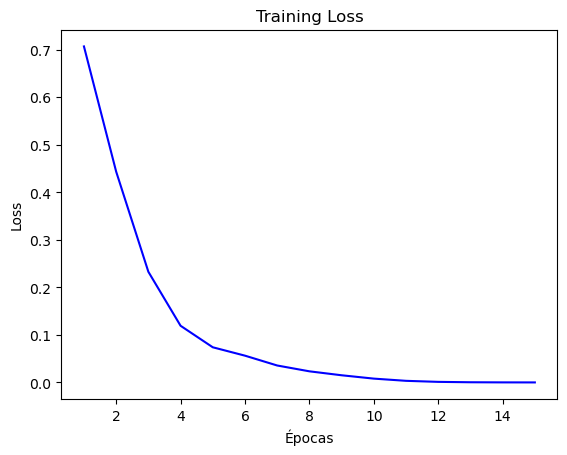

In [59]:
# Gráfico de la pérdida de entrenamiento
loss_train = historia.history['loss']
epocas = range(1, len(loss_train) + 1)

plt.plot(epocas, loss_train, 'b')
plt.title('Training Loss')
plt.xlabel('Épocas')
plt.ylabel('Loss')
plt.show()

In [60]:
modelo.evaluate(X_test, y_test)

1/1 [==============================] - 0s 213ms/step - loss: 0.0023 - accuracy: 1.0000


[0.0023124965373426676, 1.0]

1/1 [==============================] - 0s 109ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00         4

    accuracy                           1.00         8
   macro avg       1.00      1.00      1.00         8
weighted avg       1.00      1.00      1.00         8

[[4 0]
 [0 4]]


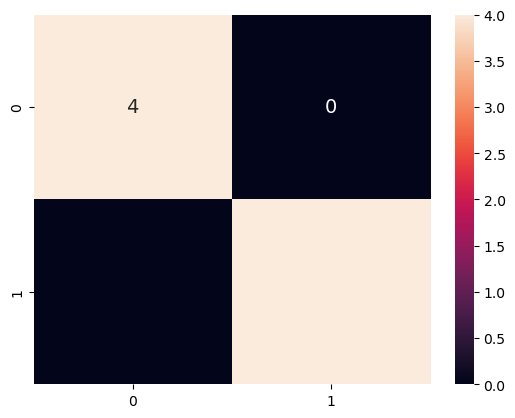

In [61]:
# Calculo de la métricas de precisión y matriz de confusión
y_pred = modelo.predict(X_test)
y_test_class = np.argmax(y_test, axis=1)
y_pred_class = np.argmax(y_pred, axis=1)

# Accuracy of the predicted values
print(classification_report(y_test_class, y_pred_class))  # Precision , Recall, F1-Score & Support
cm = confusion_matrix(y_test_class, y_pred_class)
print(cm)

# visualize the confusion matrix in a heat map
df_cm = pd.DataFrame(cm)
heatmap = sns.heatmap(df_cm, annot=True, fmt="d", annot_kws={"size": 14})

## Resultados

// Espacio para el análisis de los resultados obtenidos

## Referencias

// Incluir referencias encontradas